# Spatial mapping with Tangram

This tutorial demonstrates how to use [Tangram](https://www.nature.com/articles/s41592-021-01264-7) ([original code](https://github.com/broadinstitute/Tangram/)) to map spatial transcriptomics data. Here, we follow the corresponding [tutorial](https://squidpy.readthedocs.io/en/stable/external_tutorials/tutorial_tangram.html) at Squidpy. We do not provide much explanation, and instead refer to the original tutorial.

In scvi-tools, the `"cells"` and `"constrained"` modes of Tangram are implemented. In the `"cells"` mode, the priors will need to be calculated manually. We show this below.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

In [1]:
import tempfile

import matplotlib.pyplot as plt
import mudata
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
import squidpy as sq
from scvi.external import Tangram

In [2]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.2.0


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [3]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

## Load and preprocess data with squidpy

In [4]:
adata_sp = sq.datasets.visium_fluo_adata_crop("data/visium_fluo_adata_crop.h5ad")
adata_sp = adata_sp[adata_sp.obs.cluster.isin([f"Cortex_{i}" for i in np.arange(1, 5)])].copy()
img = sq.datasets.visium_fluo_image_crop("data/visium_fluo_image_crop.h5ad")

adata_sc = sq.datasets.sc_mouse_cortex("data/sc_mouse_cortex.h5ad")

sc.pp.filter_genes(adata_sp, min_cells=1)
sc.pp.filter_genes(adata_sc, min_cells=1)

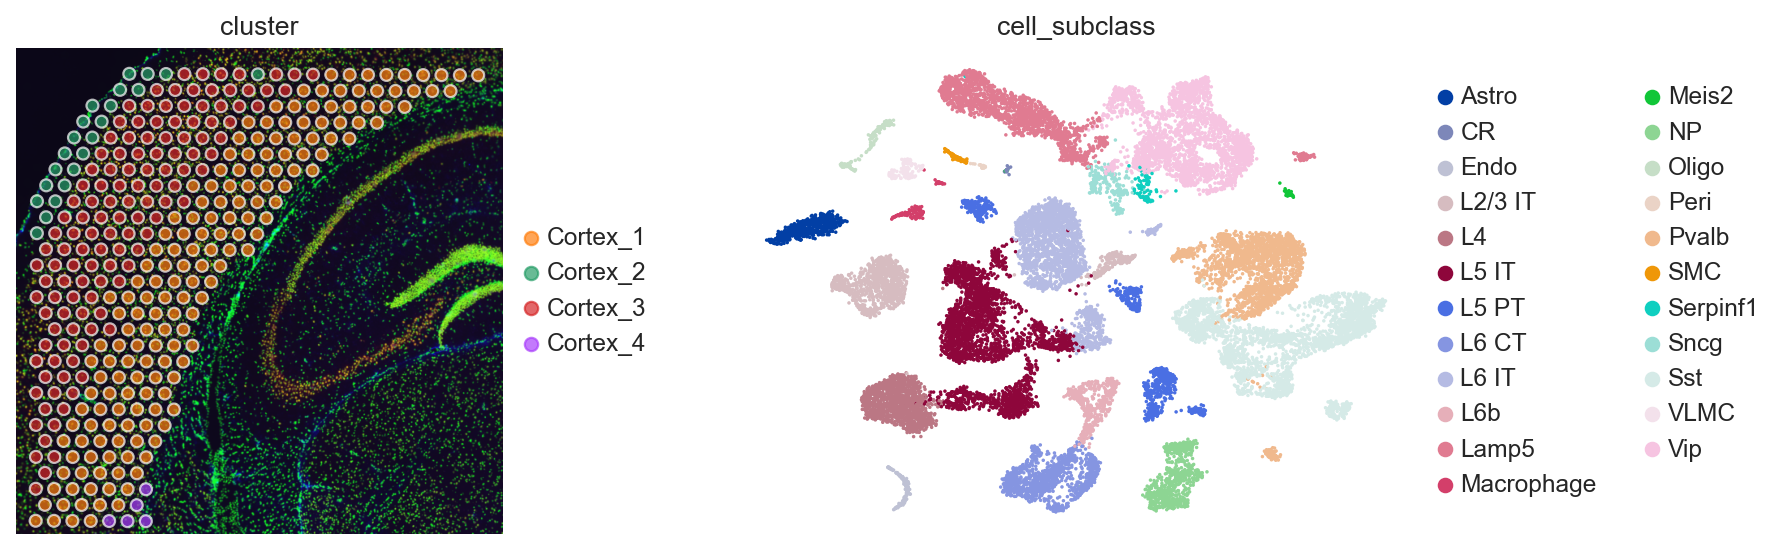

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sq.pl.spatial_scatter(adata_sp, color="cluster", alpha=0.7, frameon=False, ax=axs[0])
sc.pl.umap(adata_sc, color="cell_subclass", size=10, frameon=False, ax=axs[1])

In [6]:
mdata = mudata.MuData(
    {
        "sp": adata_sp,
        "sc": adata_sc,
    }
)

/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/mudata/_core/mudata.py:931: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility

In [7]:
sq.im.process(img=img, layer="image", method="smooth")
sq.im.segment(
    img=img,
    layer="image_smooth",
    method="watershed",
    channel=0,
)
# define image layer to use for segmentation
features_kwargs = {
    "segmentation": {
        "label_layer": "segmented_watershed",
        "props": ["label", "centroid"],
        "channels": [1, 2],
    }
}
# calculate segmentation features
sq.im.calculate_image_features(
    adata_sp,
    img,
    layer="image",
    key_added="image_features",
    features_kwargs=features_kwargs,
    features="segmentation",
    mask_circle=True,
)

  0%|          | 0/324 [00:00<?, ?/s]

/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/squidpy/im/_feature_mixin.py:355: RuntimeWarning: invalid value encountered in divide
  y = (y - np.min(y)) / (np.max(y) - np.min(y))  # type:ignore[operator]
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/squidpy/im/_feature_mixin.py:356: RuntimeWarning: invalid value encountered in divide
  x = (x - np.min(x)) / (np.max(x) - np.min(x))  # type:ignore[operator]
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/squidpy/im/_feature_mixin.py:355: RuntimeWarning: invalid value encountered in divide
  y = (y - np.min(y)) / (np.max(y) - np.min(y))  # type:ignore[operator]
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/squidpy/im/_feature_mixin.py:356: RuntimeWarning: invalid value encountered in divide
  x = (x - np.min(x)) / (np.max(x) - np.min(x))  # type:ignore[operator]
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/squidpy/im/_feature_mixin.py:355: RuntimeWarning: invalid value encountered in divide
  y

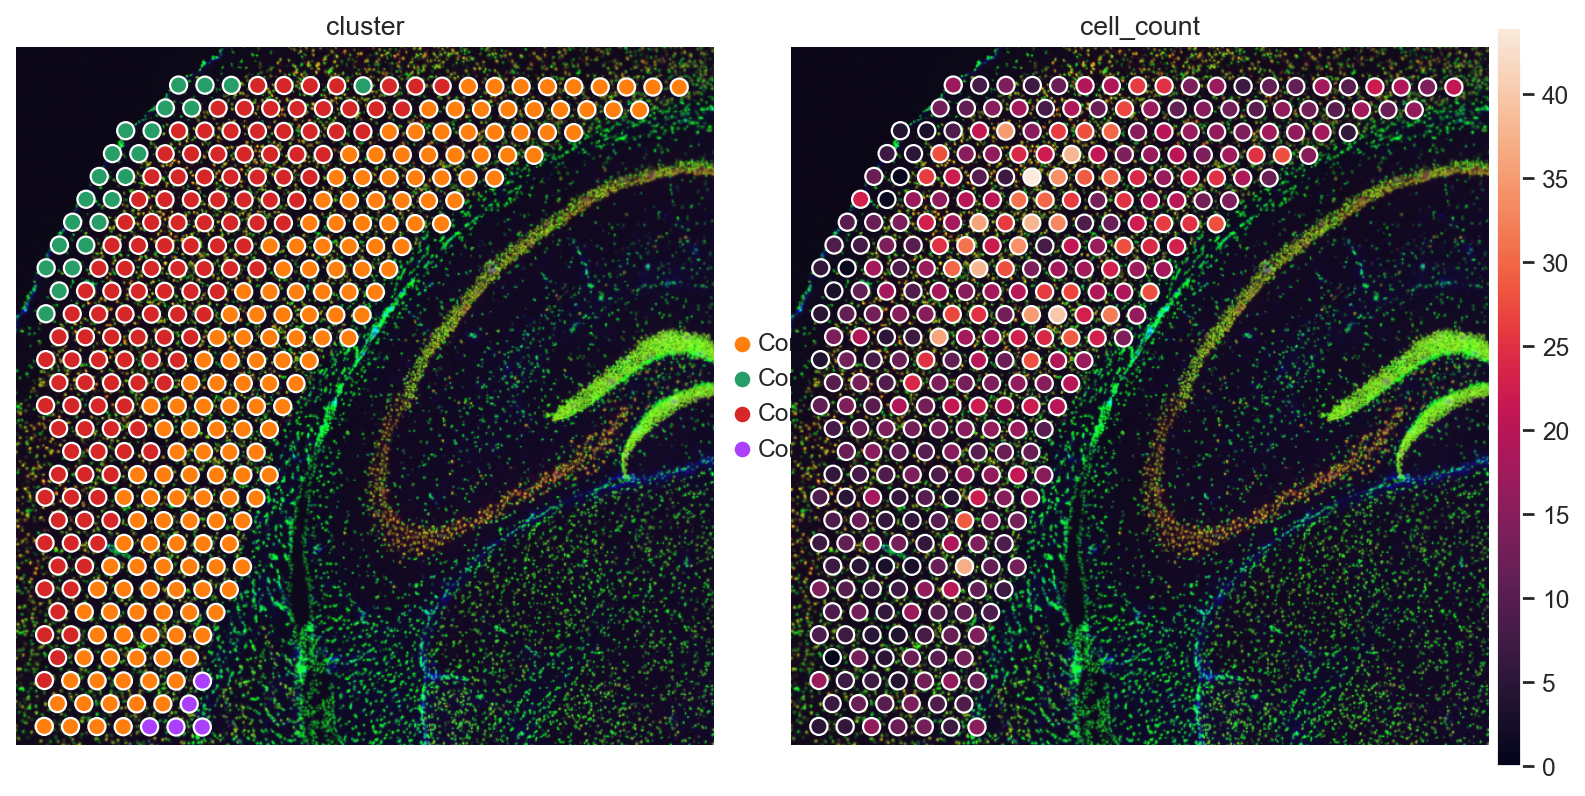

In [8]:
adata_sp.obs["cell_count"] = adata_sp.obsm["image_features"]["segmentation_label"]
sq.pl.spatial_scatter(adata_sp, color=["cluster", "cell_count"], frameon=False, wspace=0.01)

In [9]:
sc.tl.rank_genes_groups(adata_sc, groupby="cell_subclass", use_raw=False)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/opt/miniconda3/envs/scvi/lib/py

### Find genes for mapping

In [10]:
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
genes_sc = np.unique(markers_df.melt().value.values)
genes_st = adata_sp.var_names.values
genes = list(set(genes_sc).intersection(set(genes_st)))
len(genes)

1280

### Add training objects to mudata

Here we compute all the density priors we need to run Tangram.

In [12]:
target_count = adata_sp.obs.cell_count.sum()
adata_sp.obs["density_prior"] = np.asarray(adata_sp.obs.cell_count) / target_count
rna_count_per_spot = np.asarray(adata_sp.X.sum(axis=1)).squeeze()
adata_sp.obs["rna_count_based_density"] = rna_count_per_spot / np.sum(rna_count_per_spot)
adata_sp.obs["uniform_density"] = np.ones(adata_sp.X.shape[0]) / adata_sp.X.shape[0]
adata_sp.var_names_make_unique()
mdata.mod["sp"].var_names_make_unique()
mdata.mod["sc"].var_names_make_unique()
mdata.mod["sp_train"] = mdata.mod["sp"][:, genes].copy()
mdata.mod["sc_train"] = mdata.mod["sc"][:, genes].copy()
mdata.update()

/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/mudata/_core/mudata.py:931: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility

## Run Tangram

Here we run the constrained mode; however, we could have set `constrained=False`, `target_count=None`, and `density_prior_key="rna_count_based_density"` to recover Tangram's `"cells"` mode.

In [13]:
Tangram.setup_mudata(
    mdata,
    density_prior_key="density_prior",
    modalities={
        "density_prior_key": "sp_train",
        "sc_layer": "sc_train",
        "sp_layer": "sp_train",
    },
)
model = Tangram(mdata, constrained=True, target_count=target_count)
model.train()
mapper = model.get_mapper_matrix()
mdata.mod["sc"].obsm["tangram_mapper"] = mapper
labels = mdata.mod["sc"].obs.cell_subclass
mdata.mod["sp"].obsm["tangram_ct_pred"] = model.project_cell_annotations(
    mdata.mod["sc"], mdata.mod["sp"], mapper, labels
)
mdata.mod["sp_sc_projection"] = model.project_genes(mdata.mod["sc"], mdata.mod["sp"], mapper)
adata_sp.obs = adata_sp.obs.join(adata_sp.obsm["tangram_ct_pred"])

INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

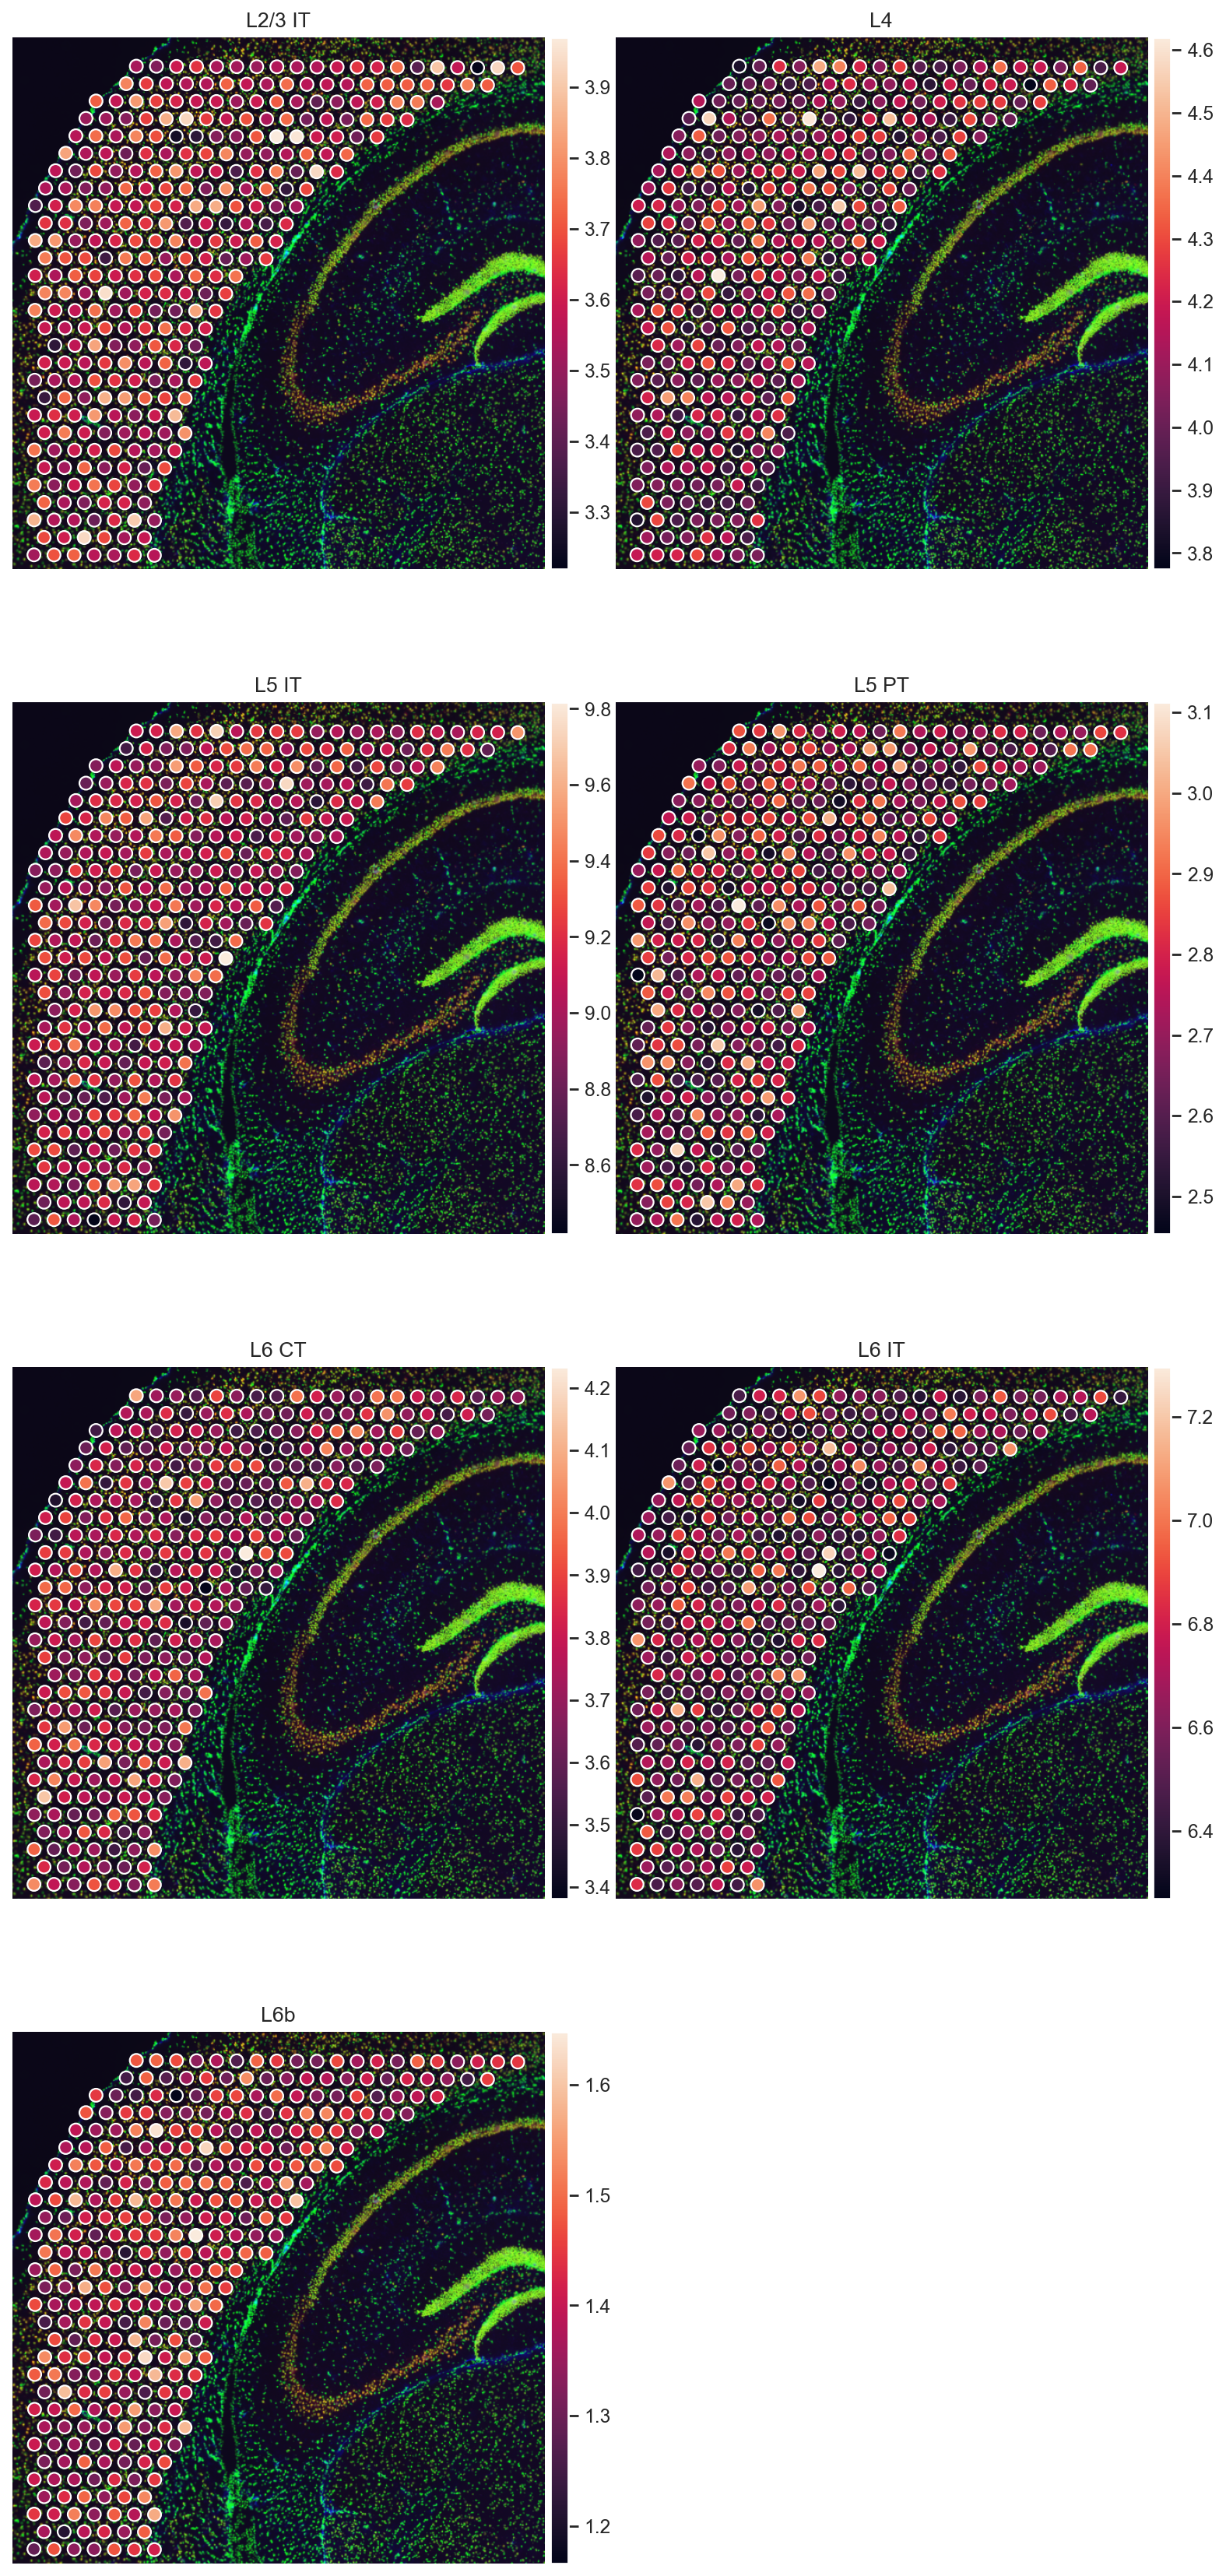

In [14]:
sq.pl.spatial_scatter(
    adata_sp,
    color=["L2/3 IT", "L4", "L5 IT", "L5 PT", "L6 CT", "L6 IT", "L6b"],
    wspace=0.01,
    ncols=2,
)